# ShOESS experiment sensitivities

This notebook calculates the sensitivity of the ShOESS (Short baseline Oscillations at the ESS) experiment, assuming a cylinder-shaped detector filled with LAB doped with Gd at 0.1%.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.constants import Avogadro
from scipy.stats import norm, chi2
from scipy.stats import rv_continuous, rv_histogram
from scipy.optimize import fmin

from IPython.display import display_markdown

from particle import literals as lp

plt.rcParams.update({
    "font.family": "serif",
    "text.usetex": True
})

In [2]:
miniboone = np.loadtxt("data/numu_disapp.csv", delimiter=",")
gallex = np.loadtxt("data/gallex.csv", delimiter=",")
gallex2 = np.loadtxt("data/gallex2.csv", delimiter=",")
reno = np.loadtxt("data/reno_neos.txt", delimiter=",")
karmen = np.loadtxt("data/karmen.txt", delimiter=",")
nomad = np.loadtxt("data/nomad.txt", delimiter=",")
prospect = np.loadtxt("data/prospect.txt", delimiter=",")
katrin = np.loadtxt("data/katrin.txt", delimiter=",")
jsns2 = np.loadtxt("data/jsns2.txt", delimiter=",")
lsnd1 = np.loadtxt("data/lsnd1.csv", delimiter=",")
lsnd2 = np.loadtxt("data/lsnd2.csv", delimiter=",")
lsnd3 = np.loadtxt("data/lsnd3.csv", delimiter=",")

In [3]:
class antinumu_dar(rv_continuous):
    """$\bar{\nu}_{\mu}$ spectrum from pion decay at rest
    https://arxiv.org/abs/1911.00762
    """
    def _pdf(self, e_nu):
        pdf = 64./lp.mu_plus.mass * ((e_nu/lp.mu_plus.mass)**2 * (3./4 - e_nu/lp.mu_plus.mass))
        if isinstance(pdf, np.ndarray):
            pdf[e_nu>lp.mu_plus.mass/2] = 0
        else:
            if e_nu>lp.mu_plus.mass/2:
                return 0
        return pdf
    
class nue_dar(rv_continuous):
    """$\nu_e$ spectrum from pion decay at rest
    https://arxiv.org/abs/1911.00762
    """
    def _pdf(self, e_nu):
        pdf = 192./lp.mu_plus.mass * ((e_nu/lp.mu_plus.mass)**2 * (1./2 - e_nu/lp.mu_plus.mass))
        
        if isinstance(pdf, np.ndarray):
            pdf[e_nu>lp.mu_plus.mass/2] = 0
        else:
            if e_nu>lp.mu_plus.mass/2:
                return 0
        return pdf    

In [4]:
L = 25 # m
ESS_NU_FLUX = 8.5e22 # nu / flavor / year
ESS_NU_E_BAR_COMPONENT = 1 / 450 # obtained with Geant4 BERT-HP simulation of the ESS beam
DETECTOR_EFFICIENCY = 0.5
YEARS = 2
RADIUS = 2 # m
LENGTH = 4 # m
VOLUME = np.pi * RADIUS * RADIUS * LENGTH * 1e6 # cm^3
CH2_MASS = 2.32e-23 # g
CH2_DENSITY = 0.86 # g/cm^3
LAB_DENSITY = 0.853 # g/cm^3
LAB_MASS = 243/Avogadro # g
LAB_C_ATOMS = 16
LAB_H_ATOMS = 26
MASS = VOLUME * LAB_DENSITY
GD_ATOMIC_MASS = 2.61e-22 # g
GD_ATOMS = MASS * 0.1 / 100 / GD_ATOMIC_MASS # 0.1% concentration in mass
C_ATOMS = LAB_DENSITY * VOLUME / LAB_MASS * LAB_C_ATOMS
H_ATOMS = LAB_DENSITY * VOLUME / LAB_MASS * LAB_H_ATOMS
NC_XSEC = 13.33e-42 # cm-2, https://journals.aps.org/prc/pdf/10.1103/PhysRevC.49.1122
IBD_H_XSEC_NUMU_BAR = 93.5e-42 # cm^-2, https://arxiv.org/abs/hep-ph/9903554, https://arxiv.org/abs/hep-ex/0203021
IBD_C_XSEC_NUMU_BAR = 8.5e-42 # cm^-2, https://arxiv.org/abs/nucl-th/0003060, https://arxiv.org/abs/hep-ex/0203021
IBD_H_XSEC_NUE_BAR = 72.0e-42 # cm^-2, https://arxiv.org/pdf/hep-ex/0203021.pdf
IBD_C_XSEC_NUE_BAR = 7.4e-42 # cm^-2, https://arxiv.org/pdf/hep-ex/0203021.pdf
CC_C_XSEC = 8.9e-42 # cm^-2, https://arxiv.org/pdf/hep-ex/0105068.pdf

In [5]:
display_markdown(fr"""## Experimental parameters
- Neutrino flux: {ESS_NU_FLUX} $\nu$ / flavor / year
- Distance from beam target: {L} m
- Detector radius: {RADIUS} m
- Detector length: {LENGTH} m
- Detector efficiency: {DETECTOR_EFFICIENCY}""", raw=True)

## Experimental parameters
- Neutrino flux: 8.5e+22 $\nu$ / flavor / year
- Distance from beam target: 25 m
- Detector radius: 2 m
- Detector length: 4 m
- Detector efficiency: 0.5

In [6]:
def appearance_prob(sin2theta2, deltam2, e, l):
    return sin2theta2*(np.sin(1.27*deltam2*l/e)**2)

def disappearance_prob(sin2theta2, deltam2, e, l):
    return 1 - sin2theta2*np.sin(1.27*deltam2*l/e)**2

In [7]:
FLUX_NORM = ESS_NU_FLUX  / (4 * np.pi * L * 100 * L * 100) * DETECTOR_EFFICIENCY

ibd_events = (
    FLUX_NORM
    * YEARS
    * (H_ATOMS * IBD_H_XSEC_NUMU_BAR + C_ATOMS * IBD_C_XSEC_NUMU_BAR)
)
miniboone_best_point = (0.807, 0.043) # https://arxiv.org/abs/2006.16883
ls = np.linspace(L - LENGTH / 2, L + LENGTH / 2, 5)
es = np.linspace(0.5, lp.mu_minus.mass / 2, int(np.ceil(lp.mu_minus.mass / 2 * 2)))
e_spectrum, l_spectrum = np.meshgrid(es, ls, indexing="ij")
miniboone_average_prob = np.average(
    np.mean(
        appearance_prob(
            miniboone_best_point[0], miniboone_best_point[1], e_spectrum, l_spectrum
        ),
        axis=1,
    ),
    weights=antinumu_dar().pdf(es),
)
ibd_events_miniboone_oscillated = ibd_events * miniboone_average_prob
display_markdown(
    "## IBD events for %i year%s of data taking" % (YEARS, "s" if YEARS > 1 else ""),
    raw=True,
)
display_markdown(f"IBD events with 100% oscillation: {ibd_events:.2e}", raw=True)
display_markdown(
    f"Oscillated IBD events at MiniBooNE best point: {ibd_events_miniboone_oscillated:.2e}",
    raw=True,
)

## IBD events for 2 years of data taking

IBD events with 100% oscillation: 2.95e+05

Oscillated IBD events at MiniBooNE best point: 6.09e+02

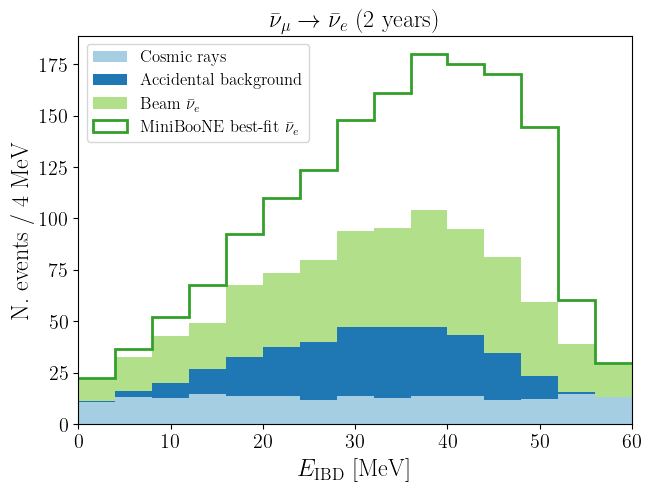

In [8]:
paired_colors = plt.get_cmap("Paired").colors

fig, ax = plt.subplots(1, 1, constrained_layout=True)
n_bins = 15
energy_range = (0, 60)
bin_size = (energy_range[1] - energy_range[0]) / n_bins

n_events = 10000
nue_events = nue_dar(a=0, b=60).rvs(size=n_events)
smeared_nues = np.random.normal(nue_events, 0.15 / np.sqrt(nue_events) * nue_events)

antinumu_events = antinumu_dar(a=0, b=60).rvs(size=n_events)
smeared_anti_numus = np.random.normal(
    antinumu_events, 0.15 / np.sqrt(antinumu_events) * antinumu_events
)
n_antinumu, bins = np.histogram(
    smeared_anti_numus, bins=n_bins, range=energy_range, density=True
)
e_centers = (bins[:-1] + bins[1:]) / 2

n_anti_nue, bins_anti_nue = (
    np.array(
        [
            0.00440658, 0.00749119, 0.01116334, 0.01086957, 0.01747944,
            0.01821387, 0.01982961, 0.02247356, 0.02320799, 0.02776146,
            0.02643948, 0.02408931, 0.01747944, 0.01057579, 0.00851939,
        ]
    ),
    np.array(
        [
            0.0, 4.0,
            8.0, 12.0,
            16.0, 20.0,
            24.0, 28.0,
            32.0, 36.0,
            40.0, 44.0,
            48.0, 52.0,
            56.0, 60.0,
        ]
    ),
)
antinue_pdf = rv_histogram((n_anti_nue, bins_anti_nue))
smeared_antinue = antinue_pdf.rvs(size=n_events)

COSMICS_BKG = 98 # From CORSIKA simulation

n_cosmics_ibd, _, _ = ax.hist(
    np.random.uniform(0, 60, COSMICS_BKG * YEARS * 10),
    bins=n_bins,
    range=energy_range,
    lw=2,
    color=paired_colors[0],
    weights=(np.full(COSMICS_BKG * YEARS * 10, 1 / 10)),
    label=f"Cosmic rays",
)

ACC_IBD_BKG = 130
n_acc_ibd, _, _ = ax.hist(
    smeared_nues,
    bins=n_bins,
    range=energy_range,
    lw=2,
    color=paired_colors[1],
    weights=(np.full(n_events, ACC_IBD_BKG * YEARS / n_events)),
    bottom=n_cosmics_ibd,
    label=r"Accidental background",
)

N_ANTINUE = FLUX_NORM * (H_ATOMS * IBD_H_XSEC_NUE_BAR + C_ATOMS * IBD_C_XSEC_NUE_BAR) * ESS_NU_E_BAR_COMPONENT
n_antinue, _, _ = ax.hist(
    smeared_antinue,
    bins=n_bins,
    range=energy_range,
    lw=2,
    color=paired_colors[2],
    weights=(np.full(n_events, N_ANTINUE * YEARS/ n_events)),
    bottom=n_cosmics_ibd + n_acc_ibd,
    label=r"Beam $\bar{\nu}_e$",
)


n_signal_ibd, _, _ = ax.hist(
    smeared_anti_numus,
    bins=n_bins,
    range=energy_range,
    lw=2,
    color=paired_colors[3],
    weights=(np.full(n_events, ibd_events_miniboone_oscillated / n_events)),
    histtype="step",
    bottom=n_antinue + n_acc_ibd + n_cosmics_ibd,
    label=r"MiniBooNE best-fit $\bar{\nu}_e$",
)

ax.set_xlim(*energy_range)
ax.tick_params(axis="both", which="major", labelsize="x-large")
ax.set_xlabel(r"$E_{\mathrm{IBD}}$ [MeV]", fontsize="xx-large")
ax.set_ylabel("N. events / 4 MeV", fontsize="xx-large")
ax.legend(fontsize="large")
ax.set_title(r"$\bar{\nu}_{\mu}\rightarrow\bar{\nu}_e$ (%i year%s)" % (YEARS, "s" if YEARS > 1 else ""), fontsize="xx-large")
fig.savefig("nue_app_spectrum.pdf")

In [9]:
TIME_CUT_EFFICIENCY = 0.3 # 2 beam spills cut

cc_events = (
    FLUX_NORM
    * YEARS
    * TIME_CUT_EFFICIENCY
    * C_ATOMS * CC_C_XSEC
)

gallex_best_point = (0.38, 7.3) # https://arxiv.org/abs/2201.07364
gallex_average_prob = np.average(
    np.mean(
        disappearance_prob(
            gallex_best_point[0], gallex_best_point[1], e_spectrum, l_spectrum
        ),
        axis=1,
    ),
    weights=nue_dar().pdf(es),
)
cc_events_gallex_oscillated = cc_events * (1 - gallex_average_prob)
display_markdown(
    "## CC events for %i year%s of data taking" % (YEARS, "s" if YEARS > 1 else ""),
    raw=True,
)
display_markdown(f"CC events with 0% oscillation: {cc_events:.2e}", raw=True)
display_markdown(
    f"Disappeared CC events at GALLEX+SAGE+BEST best point: {cc_events_gallex_oscillated:.2e}",
    raw=True,
)

## CC events for 2 years of data taking

CC events with 0% oscillation: 4.91e+03

Disappeared CC events at GALLEX+SAGE+BEST best point: 9.39e+02

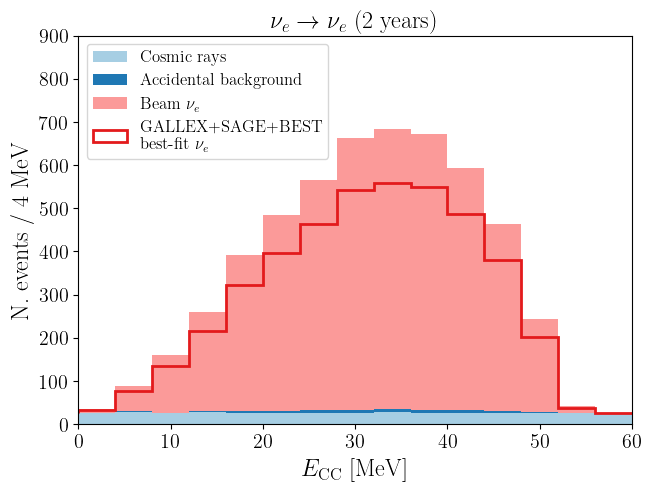

In [10]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)
n_nues, bins_nues = np.histogram(
    smeared_nues, bins=n_bins, range=energy_range, density=True
)

n_cosmics_cc, _, _ = ax.hist(
    np.random.uniform(0, 60, COSMICS_BKG * 2 * YEARS * 10),
    bins=n_bins,
    range=energy_range,
    lw=2,
    color=paired_colors[0],
    weights=(np.full(COSMICS_BKG * 2 * YEARS * 10, 1 / 10)),
    label="Cosmic rays",
)

ACC_CC_BKG = 31
n_acc_cc, _, _ = ax.hist(
    smeared_nues,
    bins=n_bins,
    range=energy_range,
    lw=2,
    color=paired_colors[1],
    weights=(np.full(n_events, ACC_CC_BKG * YEARS / n_events)),
    bottom=n_cosmics_cc,
    label=r"Accidental background",
)

n_nue, _, _ = ax.hist(
    smeared_nues,
    bins=n_bins,
    range=energy_range,
    lw=2,
    color=paired_colors[4],
    weights=(np.full(n_events, cc_events / n_events)),
    bottom=n_cosmics_cc + n_acc_cc,
    label=r"Beam $\nu_e$",
)

n_signal_cc, _, _ = ax.hist(
    smeared_nues,
    bins=n_bins,
    range=energy_range,
    lw=2,
    color=paired_colors[5],
    weights=(np.full(n_events, (cc_events - cc_events_gallex_oscillated) / n_events)),
    histtype="step",
    bottom=n_cosmics_cc + n_acc_cc,
    label="GALLEX+SAGE+BEST\nbest-fit " + r"$\nu_e$",
)

ax.set_xlim(*energy_range)
ax.tick_params(axis="both", which="major", labelsize="x-large")
ax.set_xlabel(r"$E_{\mathrm{CC}}$ [MeV]", fontsize="xx-large")
ax.set_ylabel("N. events / 4 MeV", fontsize="xx-large")
ax.legend(fontsize="large")
ax.set_ylim(0, 900)
ax.set_title(r"$\nu_e\rightarrow\nu_e$ (2 years)", fontsize="xx-large")
fig.savefig("nue_disapp_spectrum.pdf")

## Unitarity violation

A short-baseline neutrino experiment such as ShOESS is sensitive to zero-distance effects caused by unitarity violation. Here we calculate the sensitivity to the electron row parameter $N_e$ and to the electron-muon triangle closure parameter $t_{e \mu}$.

In [11]:
def unitarity_mb(bkg_sys, years):
    n_e_2 = np.linspace(0.81, 1.21, 100)
    n_mu_2 = np.linspace(0.8,1.2, 100)
    t_emu_2 = np.logspace(-5, -2, 100)

    def unitarity_chi2_n_e_2(x0, n_e_2, sigma_bkg=0.05):
        n = x0

        p_ee = n_e_2

        obs_cc = p_ee * CC_C_XSEC * C_ATOMS * FLUX_NORM * TIME_CUT_EFFICIENCY * n_nues * bin_size * years
        exp_cc = CC_C_XSEC * C_ATOMS * FLUX_NORM * TIME_CUT_EFFICIENCY * n_nues * bin_size * years
        
        chi2 = (exp_cc -  obs_cc * (1 + n))**2 / (exp_cc + n_acc_cc / YEARS * years + n_cosmics_cc / YEARS * years)
        chi2 += (n / sigma_bkg)**2

        return np.sum(chi2)


    def unitarity_chi2_n_mu_2(x0, n_mu_2, sigma_bkg=0.05):
        n, n_e_2 = x0
        
        p_ee = n_e_2
        p_mumu = n_mu_2

        obs_nc = (p_ee * NC_XSEC + p_mumu * NC_XSEC * 2) * FLUX_NORM * C_ATOMS
        exp_nc = NC_XSEC * C_ATOMS * 3 * FLUX_NORM

        chi2 = (exp_nc - obs_nc*(1+n))**2/exp_nc
        chi2 += (n/sigma_bkg)**2
        
        return chi2

    def unitarity_chi2_t_emu_2(x0, t_emu_2, sigma_bkg=0.05):
        n_sig, n_bkg = x0
        p_mue = t_emu_2

        sig = n_antinumu * p_mue * (IBD_H_XSEC_NUMU_BAR * H_ATOMS + IBD_C_XSEC_NUMU_BAR * C_ATOMS) * FLUX_NORM * years * bin_size
        bkg = n_anti_nue * (IBD_H_XSEC_NUE_BAR * H_ATOMS + IBD_C_XSEC_NUE_BAR * C_ATOMS) * FLUX_NORM * ESS_NU_E_BAR_COMPONENT * years * bin_size
        exp_ibd = bkg
        obs_ibd = bkg*(1+n_bkg) + sig*(1+n_sig)

        if np.any(obs_ibd) > 0:
            chi2 = (exp_ibd - obs_ibd)**2 / (exp_ibd + n_acc_ibd / YEARS * years + n_cosmics_ibd / YEARS * years)
            chi2 += (n_bkg / 0.25)**2
            chi2 += (n_sig / sigma_bkg)**2

            return np.sum(chi2)
        
        return np.inf
    
    t_emu_2_chi2 = []
    for this_t_emu_2 in t_emu_2:
        min_chi2 = fmin(unitarity_chi2_t_emu_2, np.array([1, 1]), args=(this_t_emu_2, bkg_sys), disp=False, ftol=1e-12, xtol=1e-12, full_output=True)[1]
        t_emu_2_chi2.append(min_chi2)
        
    n_e_2_chi2 = []
    for this_n_e_2 in n_e_2:
        min_chi2 = fmin(unitarity_chi2_n_e_2, np.array([1]), args=(this_n_e_2, bkg_sys), disp=False, ftol=1e-9, xtol=1e-9, full_output=True)[1]
        n_e_2_chi2.append(min_chi2)

    n_mu_2_chi2 = []
    for this_n_mu_2 in n_mu_2:
        min_chi2 = fmin(unitarity_chi2_n_mu_2, np.array([1, 1e-2]), args=(this_n_mu_2, bkg_sys), disp=False, ftol=1e-9, xtol=1e-9, full_output=True)[1]
        n_mu_2_chi2.append(min_chi2)

    return np.array(t_emu_2), np.array(t_emu_2_chi2), np.array(n_e_2), np.array(n_e_2_chi2), np.array(n_mu_2), np.array(n_mu_2_chi2)


In [12]:
t_emu_2, t_emu_2_chi2, n_e_2, n_e_2_chi2, n_mu_2, n_mu_2_chi2  = unitarity_mb(0.05, 2)
t_emu_2_4, t_emu_2_chi2_4, n_e_2_4, n_e_2_chi2_4, n_mu_2_4, n_mu_2_chi2_4  = unitarity_mb(0.05, 4)
t_emu_2_chi2[t_emu_2_chi2<0] = np.inf
t_emu_2_chi2_4[t_emu_2_chi2_4<0] = np.inf

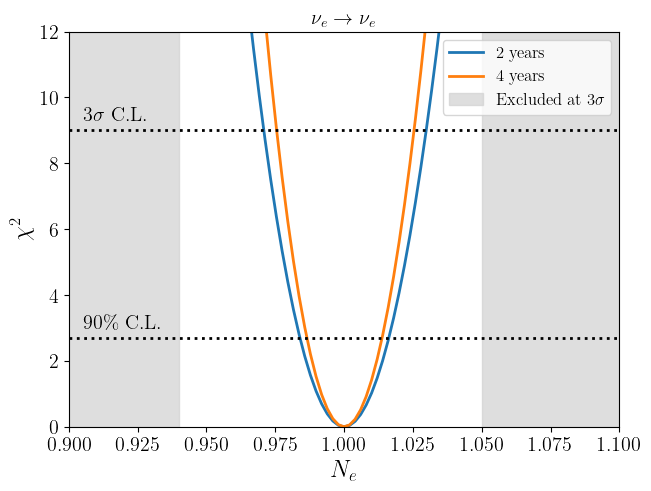

In [13]:
fig, ax = plt.subplots(1,1,constrained_layout=True)
ax.plot(np.sqrt(n_e_2), n_e_2_chi2, label='2 years', lw=2)
ax.plot(np.sqrt(n_e_2), n_e_2_chi2_4, label='4 years', lw=2)

# ax.set_xscale("log")
ax.axhline(chi2.isf(0.1, 1), ls=':', color='k')
ax.axhline(9, ls=':', color='k')

ax.set_xlim(np.sqrt(min(n_e_2)), np.sqrt(max(n_e_2)))
ax.tick_params(axis='both', which='major', labelsize='x-large')
ax.set_xlabel(r"$N_e$", fontsize='xx-large')
ax.set_ylabel(r"$\chi^2$", fontsize='xx-large')
ax.text(0.905, chi2.isf(0.1, 1)+0.3, r'90\% C.L.', fontsize='x-large', color='k')
ax.text(0.905, 9+0.3, r'$3\sigma$ C.L.', fontsize='x-large', color='k')
ax.set_ylim(0, 12)
ax.axvspan(0.8, 0.94, color='lightgray', alpha=0.75, label='Excluded at 3$\sigma$')
ax.axvspan(1.05, 1.2, color='lightgray', alpha=0.75)
ax.legend(fontsize='large', loc='upper right')

ax.set_title(r"$\nu_e\rightarrow\nu_e$", fontsize='x-large')
fig.savefig("ne.pdf")

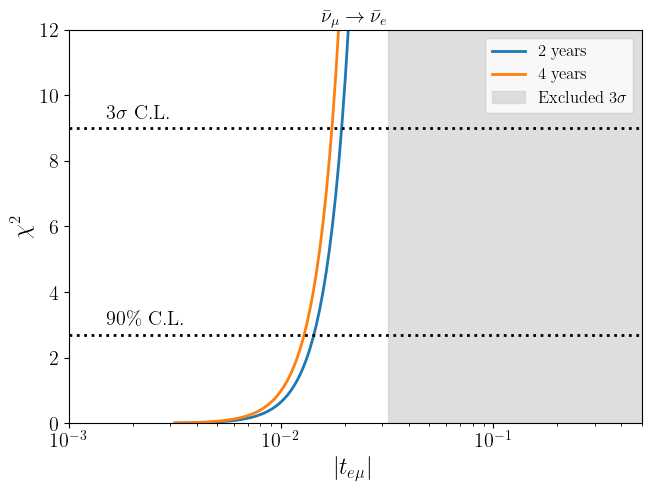

In [14]:
fig, ax = plt.subplots(1,1,constrained_layout=True)
ax.plot(np.sqrt(t_emu_2), t_emu_2_chi2,label='2 years',  lw=2)
ax.plot(np.sqrt(t_emu_2), t_emu_2_chi2_4,label='4 years',  lw=2)

ax.set_xscale("log")
ax.axhline(chi2.isf(0.1, 1), ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize='x-large')
ax.set_xlabel(r"$\left|t_{e \mu}\right|$", fontsize='xx-large')
ax.set_ylabel(r"$\chi^2$", fontsize='xx-large')
ax.text(1.5e-3, chi2.isf(0.1, 1)+0.3, r'90\% C.L.', fontsize='x-large', color='k')
ax.text(1.5e-3, 9+0.3, r'$3\sigma$ C.L.', fontsize='x-large', color='k')
ax.axhline(9, ls=':', color='k')

ax.set_ylim(0, 12)
ax.axvspan((3.2e-2), 1e0, color='lightgray', alpha=0.75, label='Excluded 3$\sigma$')
ax.set_title(r"$\bar{\nu}_{\mu}\rightarrow\bar{\nu}_e$", fontsize='x-large')

ax.legend(fontsize='large')
ax.set_xlim(1e-3, 5e-1)
fig.savefig("t_emu.pdf")


## Light sterile neutrino
Here we calculate the sensitivity of ShOESS to the (3+1) model for light sterile neutrino oscillations.

In [15]:
def app_chi2(x0, sig, bkg, bkg_other, sigma_sig=0.05, sigma_bkg=0.1):

    n_sig, n_bkg = x0
        
    exp_ibd = bkg
    obs_ibd = bkg*(1+n_bkg) + sig*(1+n_sig)

    if np.any(obs_ibd) > 0:
        chi2 = (exp_ibd - obs_ibd)**2/(exp_ibd+bkg_other)
        chi2 += (n_bkg/sigma_bkg)**2
        chi2 += (n_sig/sigma_sig)**2

        return np.sum(chi2)
    else:
        return np.inf
    
def disapp_chi2(x0, sig, bkg, bkg_other, sigma_bkg=0.05):

    n = x0
    exp = bkg
    obs = bkg*(1+n) - sig

    if np.any(obs) > 0:
        chi2 = (exp - obs)**2/(exp+bkg_other)
        chi2 += (n/sigma_bkg)**2

        return np.sum(chi2)
    else:
        return np.inf

In [16]:
def draw_chi2_contour(x, y, ax, sig, bkg, bkg_other, levels, colors, sig_sys=0.05, bkg_sys=0.05, this_chi2=app_chi2):
    chi2_sens = np.zeros(sig.shape[:2])
    
    for i in range(chi2_sens.shape[0]):
        for j in range(chi2_sens.shape[1]):
            
            try:
                this_bkg = bkg[i][j]
            except (IndexError, TypeError):
                this_bkg = bkg
            try:
                this_sig_sys = sig_sys[i][j]
            except TypeError:
                this_sig_sys = sig_sys

            try:
                this_bkg_sys = bkg_sys[i][j]
            except (IndexError, TypeError):
                this_bkg_sys = bkg_sys
                
            if this_chi2 == app_chi2:
                min_chi2 = fmin(this_chi2, np.array([0,0]), args=(sig[i][j], this_bkg, bkg_other, this_sig_sys, this_bkg_sys),ftol=1e-9, xtol=1e-9,  disp=False, full_output=True)[1]
            else:
                min_chi2 = fmin(this_chi2, 0, args=(sig[i][j], this_bkg, bkg_other, this_bkg_sys), disp=False,ftol=1e-9, xtol=1e-9,  full_output=True)[1]

            p_value = chi2.cdf(min_chi2, 2)
            chi2_sens[i][j] = 1-p_value

    h = ax.contour(x,
                   y, 
                   chi2_sens, 
                   levels,
                   colors=colors)
    
    return h



In [19]:
deltam2s = np.logspace(-2,2,100)
sin2theta2s = np.logspace(-4,0,100)
s_2d, d_2d = np.meshgrid(sin2theta2s, deltam2s, indexing='ij')

levels = [1-norm.cdf(5), 0.10]
colors = ['gold', 'mediumseagreen']

app_antinue_avg = []
for ie in range(4, 60, 4):
    es_bin = np.linspace(ie,ie+4,20)
    s_avg, d_avg, e_avg, l_avg = np.meshgrid(sin2theta2s, deltam2s, es_bin, ls, indexing='ij')
    app = np.mean(appearance_prob(s_avg, d_avg, e_avg, l_avg), axis=(2,3))
    app_antinue_avg.append(app)

app_antinue_probs = np.array(app_antinue_avg).transpose(1,2,0)

disapp_antinue_avg = []
for ie in range(4, 60, 4):
    es_bin = np.linspace(ie,ie+4,20)
    s_avg, d_avg, e_avg, l_avg = np.meshgrid(sin2theta2s, deltam2s, es_bin, ls, indexing='ij')
    disapp = np.mean(disappearance_prob(s_avg, d_avg, e_avg, l_avg), axis=(2,3))
    disapp_antinue_avg.append(disapp)

disapp_nue_probs = np.array(disapp_antinue_avg).transpose(1,2,0)

def light_sterile(years):

    fig, ax = plt.subplots(1,2, layout='constrained', figsize=(10,5))
    for i in range(2):
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        ax[i].grid()
        ax[i].set_ylabel(r"$\Delta m^2_{41}$ [eV$^2$]", fontsize='xx-large')
        ax[i].tick_params(axis='both', which='major', labelsize='x-large')

    sig_antinue_app = n_antinumu[1:] * app_antinue_probs * (IBD_H_XSEC_NUMU_BAR * H_ATOMS + IBD_C_XSEC_NUMU_BAR * C_ATOMS) * FLUX_NORM * YEARS
    bkg_antinue_app = n_anti_nue[1:] * (IBD_H_XSEC_NUE_BAR * H_ATOMS + IBD_C_XSEC_NUE_BAR * C_ATOMS) * FLUX_NORM * ESS_NU_E_BAR_COMPONENT * YEARS

    bkg_antinue_other = n_cosmics_ibd[1:] / YEARS * years + n_acc_ibd[1:] / YEARS * years
    draw_chi2_contour(s_2d, d_2d, ax[0],
                      sig_antinue_app*bin_size,
                      bkg_antinue_app*bin_size,
                      bkg_antinue_other,
                      levels,
                      colors,
                      sig_sys=0.05,
                      bkg_sys=0.25,
                      this_chi2=app_chi2)

    l1, = ax[0].plot(np.nan, np.nan, color='gold', label=r'ShOESS $5\sigma$ CL')
    l3, = ax[0].plot(np.nan, np.nan, color='mediumseagreen', label=r'ShOESS 90\% CL')

    ax[0].set_xlabel(r"$\sin^22 \theta_{\mu e}$", fontsize='xx-large')
    ax[0].set_ylim(1e-2, 1e2)
    ax[0].set_xlim(2e-4, 1)
    ax[0].set_title(r"$\bar{\nu}_{\mu}\rightarrow\bar{\nu}_e$ (%i year%s)" % (years, 's' if years > 1 else ''), fontsize='xx-large')

    k, = ax[0].plot(karmen[:,0][np.argsort(karmen[:,1])], karmen[:,1][np.argsort(karmen[:,1])], ls='--', lw=1)
    n, = ax[0].plot(nomad[:,0][np.argsort(nomad[:,1])], nomad[:,1][np.argsort(nomad[:,1])], ls='--', lw=1, c='tab:red')
    j, = ax[0].plot(jsns2[:,0][np.argsort(jsns2[:,1])], jsns2[:,1][np.argsort(jsns2[:,1])], lw=1, c='tab:purple')
    l4, = ax[0].fill(lsnd1[:,0], lsnd1[:,1], c='lightblue')
    l5, = ax[0].fill(lsnd2[:,0], lsnd2[:,1], c='lightblue')
    l6, = ax[0].fill(lsnd3[:,0], lsnd3[:,1], c='lightblue')
    mb = ax[0].scatter(miniboone_best_point[0], miniboone_best_point[1],
                        zorder=999, c='tab:blue', label="GALLEX+SAGE+BEST best fit")

    ax[0].legend([l1, l3, j, k, n, mb, l4, l5, l6],  
                 [r'ShOESS 5$\sigma$ CL', 
                  'ShOESS 95\% CL',
                  r'JSNS$^2$ 5$\sigma$ CL (2 years)',
                  r"\noindent KARMEN2 90\% C.L.\\($\bar{\nu}_e$ app.)",
                  r"\noindent NOMAD 90\% C.L.\\($\nu_e$ app.)",
                  "MiniBooNE best fit", 
                  "LSND 99\% CL (allowed)"],loc='upper right')


    tot_bkg_events = CC_C_XSEC * C_ATOMS
    bkg_dis_nue = tot_bkg_events * FLUX_NORM * disapp_nue_probs * TIME_CUT_EFFICIENCY * n_nues[1:] * years
    sig_dis_nue = tot_bkg_events * FLUX_NORM * (1-disapp_nue_probs) * TIME_CUT_EFFICIENCY * n_nues[1:] * years

    best = ax[1].scatter(gallex_best_point[0], gallex_best_point[1], zorder=999, c='tab:blue', label="GALLEX+SAGE+BEST best fit")
    bkg_nue_other = n_cosmics_cc[1:] / YEARS * years + n_acc_cc[1:] / YEARS * years

    draw_chi2_contour(s_2d, d_2d, ax[1],
                      -sig_dis_nue*bin_size,
                      bkg_dis_nue*bin_size,
                      bkg_nue_other,
                      levels,
                      colors,
                      bkg_sys=0.05,
                      this_chi2=disapp_chi2)

    ax[1].set_xlabel(r"$\sin^22 \theta_{ee}$", fontsize='xx-large')
    ax[1].set_ylim(1e-1, 40)
    ax[1].set_xlim(2e-3, 1)

    ax[1].set_title(r"$\nu_e\rightarrow \nu_s$ (%i year%s)" % (years, 's' if years > 1 else ''), fontsize='xx-large')

    g, = ax[1].fill(gallex[:,0], gallex[:,1], label='GALLEX+SAGE+BEST\n95\% CL (allowed)', c='lightblue')
    r, = ax[1].plot(reno[:,0][np.argsort(reno[:,1])], reno[:,1][np.argsort(reno[:,1])], ls='--', lw=1, label='RENO+NEOS 95\% CL')
    p, = ax[1].plot(prospect[:,0][np.argsort(prospect[:,1])], prospect[:,1][np.argsort(prospect[:,1])], ls='--', lw=1, label='PROSPECT 95\% CL')
    k, = ax[1].plot(katrin[:,0][np.argsort(katrin[:,1])], katrin[:,1][np.argsort(katrin[:,1])], ls='--', lw=1, label='KATRIN 95\% CL', c='tab:red')

    ax[1].fill(gallex2[:,0], gallex2[:,1], c='lightblue')
    ax[1].legend(
        [l1, l3, g, best, r, p, k],
        [r'ShOESS 5$\sigma$ CL', 'ShOESS 90\% CL',
         'GALLEX+SAGE+BEST\n95\% CL (allowed)', "GALLEX+SAGE+BEST\nbest fit", 'RENO+NEOS 95\% CL', 'PROSPECT 95\% CL', 'KATRIN 95\% CL'],
        loc='upper left')

    fig.savefig("sensitivity.pdf", transparent=True)


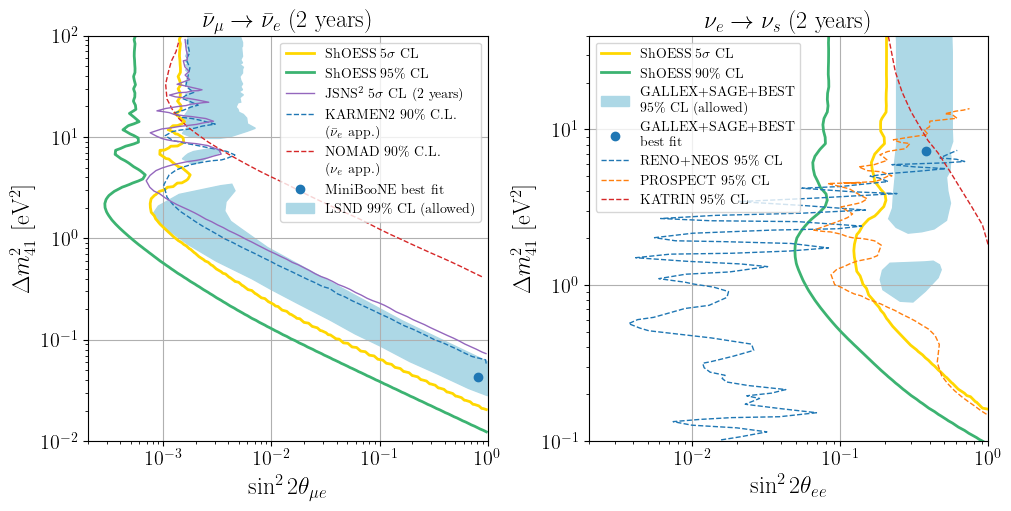

In [20]:
light_sterile(2)

<!-- ## $\bar{\nu}_{\mu}\rightarrow\bar{\nu}_{e}$ appearance 
This happens through inverse beta decay on C and free protons

\begin{align}
    \bar{\nu}_{e} + ^{12}C &\rightarrow e^+ + ^{11}B + n\\
    \bar{\nu}_{e} + p &\rightarrow e^+ + n
\end{align}

followed by neutron capture and the emission of a 2.2 MeV $\gamma$.


## $\nu_{\mu}$ disappearance
Here we look for a deficit of muon neutrinos through the neutral current channel

\begin{equation}
    \nu_{\mu} + ^{12}C \rightarrow \nu_{\mu} + ^{12}C^*
\end{equation}

and the subsequent emission of 15.11 MeV $\gamma$.

## $\nu_e$ disappearance
Here we look for a deficit of electron neutrinos through the charged current channel

\begin{equation}
    \nu_e + ^{12}C \rightarrow e^- + ^{12}N_{gs}
\end{equation}

followed by the $\beta^+$ decay of $^{12}N_{gs}$ into $^{12}C$ with the emission of one positron. -->